In [127]:
#Make sure that you have all these libaries available to run the code successfully
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install sklearn
# !pip install keras
# !pip install tensorflow
!pip install mxnet gluonts ujson
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shutil
from datetime import datetime
from datetime import timedelta
# !pip uninstall pystan -y
# !pip install pystan~=2.14
# !pip install fbprophet
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
from numpy import mean
from numpy import std
# !pip install mxnet gluonts ujson
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime, date, time
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [128]:
def prepare_crypto_df(file_name):
    crypto_price_df = pd.read_csv(file_name, header=0, index_col=1)
    crypto_price_df = crypto_price_df[['close']]
    crypto_price_df.index.names = ['Date']
    crypto_price_df.columns = ['Count']
    return crypto_price_df

In [129]:
#loading data 
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
deep_ds = transactions.drop(['Value'], axis=1)
transaction_values = transactions.drop(['Price'], axis=1)
transaction_values.columns = ['Count']
ethprice = prepare_crypto_df('Binance_ETHUSDT_minute.csv')
maticprice = prepare_crypto_df('Binance_MATICUSDT_minute.csv')


In [130]:
# features
features = []
names = []
features.append(ethprice)
names.append('ethprice')
# features.append(maticprice)
# names.append('maticprice')
features.append(transaction_values)
names.append('transaction_values')
features.append(pd.read_csv('blocks.csv', header=0, index_col=0))
names.append('blocks')
features.append(pd.read_csv('token_transfers.csv', header=0, index_col=0))
names.append('token_transfers')
features.append(pd.read_csv('traces.csv', header=0, index_col=0))
names.append('traces')
features.append(pd.read_csv('logs.csv', header=0, index_col=0))
names.append('logs')


In [131]:
!unzip -o data.zip

Archive:  data.zip
  inflating: Binance_ETHUSDT_minute.csv  
  inflating: Binance_MATICUSDT_minute.csv  
  inflating: blocks.csv              
  inflating: logs.csv                
  inflating: token_transfers.csv     
  inflating: traces.csv              
  inflating: transactions.csv        


In [132]:
def normalize_df(df):
    # return (df-df.mean())/df.std()
    return (df-df.min())/(df.max()-df.min())

In [133]:
ENABLE_FEATURES = True
RUN_MODEL = False
DELTA = 40
AGG = 20
FREQ = str(AGG) + 'min'

deep_ds=deep_ds.sort_index()
deep_ds.index = pd.to_datetime(deep_ds.index)
deep_ds = deep_ds.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()
end = deep_ds.index[-1]
test_cnt = int(0.2*deep_ds.shape[0])
test_start = deep_ds.shape[0] - test_cnt
train_ds = deep_ds[:deep_ds.index[test_start]]

start = deep_ds.index[deep_ds.shape[0] - test_cnt + 1]
end = deep_ds.index[-1] - timedelta(minutes=DELTA*AGG)
test_ds = deep_ds[deep_ds.index[deep_ds.shape[0] - test_cnt + 1]:end]

train_features = []
test_features = []

def fill_feature(reference_ds, feature):
    for date_entry in reference_ds.index:
        if not date_entry in feature.index:
            feature.loc[date_entry] = 0
            
for i in range(len(features)):
    features[i]=features[i].sort_index()
    features[i].index = pd.to_datetime(features[i].index)
    features[i] = features[i][deep_ds.index[0]:deep_ds.index[-1]]
    if features[i].shape[0] != deep_ds.shape[0]:
        fill_feature(deep_ds, features[i])

    features[i] = features[i].groupby(pd.Grouper(level='Date', freq=FREQ)).mean()
    features[i] = features[i]["Count"]
    features[i] = normalize_df(features[i])
    train_features.append(features[i][:deep_ds.index[test_start]])
    test_features.append(features[i][features[i].index[deep_ds.shape[0] - test_cnt + 1]:end])
    

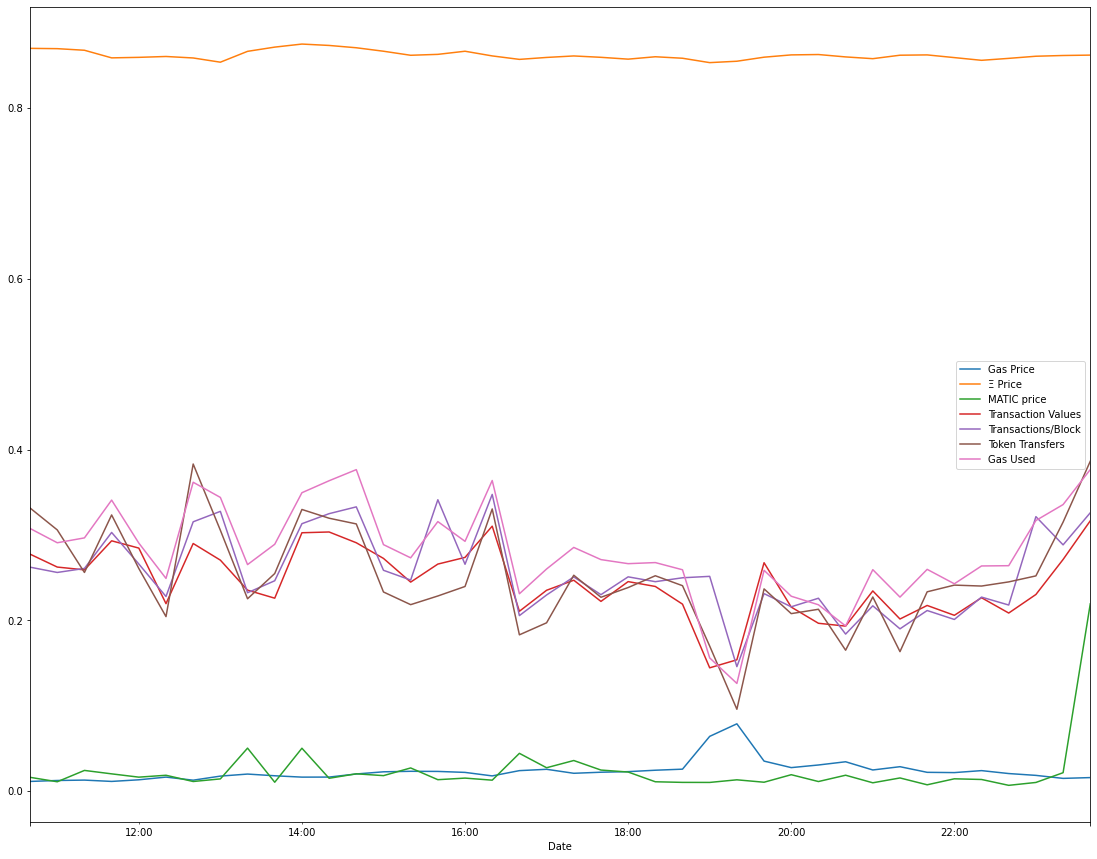

In [134]:
RANGE = DELTA
column_names = ['Gas Price', 'Ξ Price', 'MATIC price', 'Transaction Values', 'Transactions/Block', 'Token Transfers', 'Gas Used']
fig, ax = plt.subplots(1, 1, figsize=(19, 15))
ns = normalize_df(deep_ds)
correlation_df = pd.DataFrame(ns[-RANGE:])
correlation_df.columns = [column_names[0]]
ns[-RANGE:].plot(ax=ax)
for i in range(len(features)):
    features[i][-RANGE:].plot(ax=ax)
    correlation_df[column_names[i + 1]] = features[i][-RANGE:]

# fig.suptitle('Normalized Feature Values', fontsize=20)

plt.legend(column_names, loc="best", prop={'size': 10})
plt.show()


In [149]:
df_corr = correlation_df.corr()
df_corr.to_latex('corr.tex', float_format='%.2f')
df_corr

,Gas Price,Ξ Price,MATIC price,Transaction Values,Transactions/Block,Token Transfers,Gas Used
Gas Price,1.000000,-0.441298,-0.143281,-0.708723,-0.516904,-0.708408,-0.773658
Ξ Price,-0.441298,1.000000,0.081790,0.485708,0.325694,0.394839,0.461708
MATIC price,-0.143281,0.081790,1.000000,0.320767,0.224258,0.342344,0.290561
Transaction Values,-0.708723,0.485708,0.320767,1.000000,0.792918,0.855414,0.924041
Transactions/Block,-0.516904,0.325694,0.224258,0.792918,1.000000,0.792345,0.881172
Token Transfers,-0.708408,0.394839,0.342344,0.855414,0.792345,1.000000,0.910394
Gas Used,-0.773658,0.461708,0.290561,0.924041,0.881172,0.910394,1.000000


/home/andras/anaconda3/envs/deepar/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.
/home/andras/anaconda3/envs/deepar/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


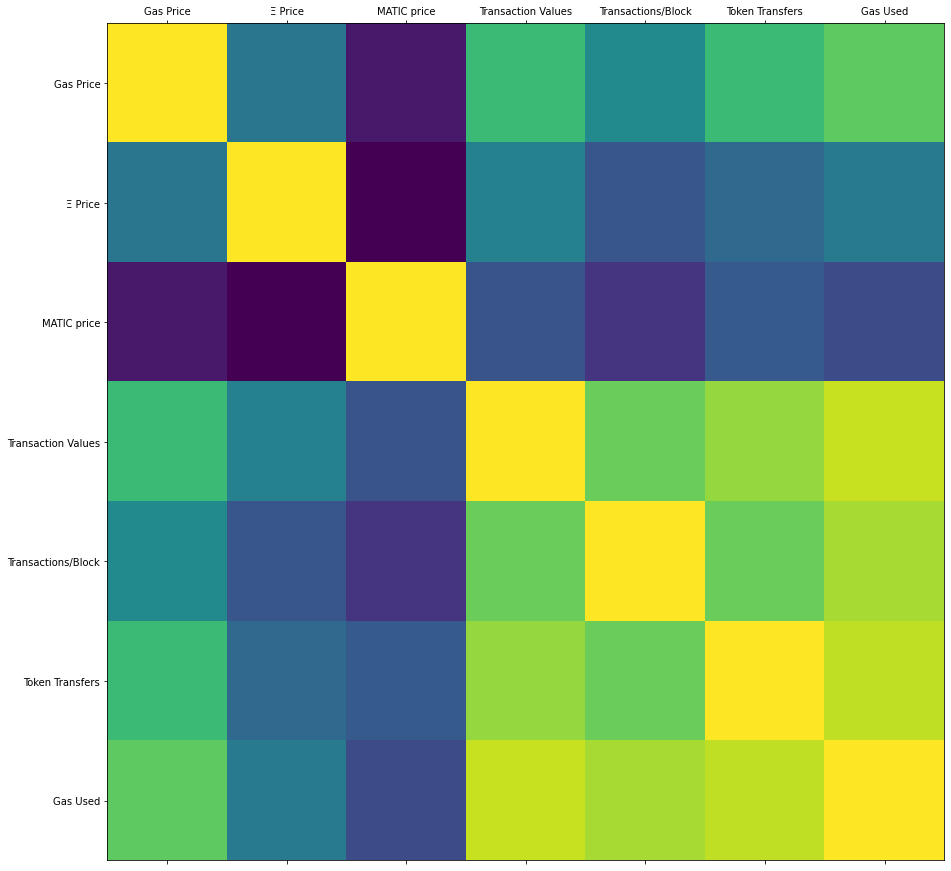

In [150]:
plt.figure(figsize=(15,15))
plt.matshow(df_corr.abs(), fignum=1)
ax = plt.gca()
ax.set_xticklabels([column_names] + column_names)
ax.set_yticklabels([column_names] + column_names)
plt.show()

In [137]:
dyn_features = [feature for feature in train_features]

training_data = ListDataset(
    [{"start": deep_ds.index[0], "target": train_ds['Price']
    ,'feat_dynamic_real': dyn_features
    }],
    freq = FREQ
)

In [138]:
feature_cnt = len(features) if ENABLE_FEATURES else 0

In [139]:
model_path = "./pred_{}_{}_{}/".format(DELTA, AGG, feature_cnt)

if RUN_MODEL:
    callbacks = [
        LearningRateReduction(objective="min",
                            patience=10,
                            base_lr=5e-3,
                            decay_factor=0.5,
                            ),
        ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
    ]

    estimator = DeepAREstimator(
        freq=FREQ,      
        prediction_length=DELTA,
        context_length=2*DELTA,
        num_layers = 4,
        num_cells = 40,
        use_feat_dynamic_real = ENABLE_FEATURES,
        cell_type='gru',
        distr_output=StudentTOutput(),
        dropout_rate=0.01,
        trainer=Trainer(#ctx = mx.context.gpu(),
                        epochs=200,
                        callbacks=callbacks))

    predictor = estimator.train(training_data)
    if os.path.exists(model_path):
        shutil.rmtree(model_path)
    os.mkdir( model_path)
    predictor.serialize(Path(model_path))
else:
    predictor = Predictor.deserialize(Path(model_path))


In [140]:
end_date = datetime.combine(date(2021, 10, 17), time(6,0))
start_date = end_date - timedelta(10*AGG*DELTA) 
test_ds = test_ds[start_date:end_date]['Price']
dyn_features = [feature[start_date:end_date] for feature in test_features]

In [141]:
test_data = ListDataset(
    [{"start": test_ds.index[0], "target": test_ds
    ,'feat_dynamic_real': dyn_features
    }],
    freq = FREQ
)

In [142]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

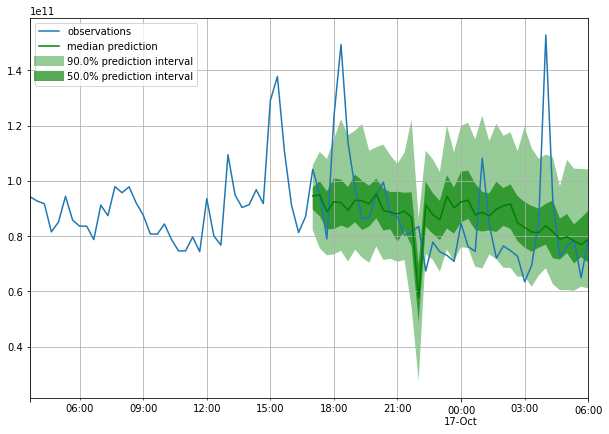

In [143]:
image_file = "pred_{}_{}_{}_{}.jpg".format(end_date, DELTA, AGG, feature_cnt)

def plot_prob_forecasts(ts_entry, forecast_entry, image_file):
    plot_length = 80
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.savefig(image_file, dpi=150, bbox_inches='tight')
    plt.show()
    

plot_prob_forecasts(tss[0], forecasts[0], image_file)

In [144]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9], ignore_invalid_values=True)
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=1)


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


In [145]:

csv_file = "pred_{}_{}_{}_{}.json".format(end_date, DELTA, AGG, feature_cnt)
with open(csv_file, 'w') as writer:
    writer.write(json.dumps(agg_metrics, indent=4))


In [146]:

print('Last run:', image_file, csv_file)

Last run: pred_2021-10-17 06:00:00_40_20_6.jpg pred_2021-10-17 06:00:00_40_20_6.json
